In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import os

path = 'result/synchronize'
if not os.path.exists(path):
    os.makedirs(path)

def dxdt(F, X, t, h=1e-2):
    assert(len(F )==len(X))
    X = np.array(X)
    K1 = np.array([f(X, t) for f in F])
    dX = h* K1 / 2
    K2 = np.array([f(X + dX, t + h / 2) for f in F])
    dX = h * K2 / 2
    K3 = np.array([f(X + dX, t + h / 2) for f in F])
    dX = h * K3
    K4 = np.array([f(X + dX, t + h) for f in F])
    dX = (K1 + 2 * K2 + 2 * K3 + K4) * h / 6
    return dX

def trajectory(F, initial_point, num_points=1e4, h=1e-2):
    assert (len(F) == len(initial_point))

    n = int(num_points)
    dim = len(initial_point)
    X = np.zeros([n, dim])

    X[0, :] = initial_point
    for k in range(1, n):
        dX = dxdt(F, X[k - 1, :], h * (k - 1), h)
        X[k, :] = X[k - 1, :] + dX

    return X.T

def show(x):
        x = np.atleast_2d(x)
        print(x.shape)
        plt.figure(figsize=(20, 6))
        dim = ['x', 'y', 'z']
        for i in range(x.shape[0]):
            plt.subplot(3, 1, i + 1)
            plt.plot(x[i, :].T, color='green', label='train set')
            plt.ylabel(dim[i])
            plt.legend(loc='upper right')
        plt.xlabel('t')
        plt.show()


def show_3d(x):
    x = np.atleast_2d(x)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    plt.plot(*x[:3, :], 'green', label='train set')
    # plt.plot(*model.W_i[:,:3].T, 'ko',label='hidden layer')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    # plt.savefig('../figures/' + system_name + '_split.pdf')
    plt.show()

In [2]:
def Lorenz():
    '''
    2 vortex lorentz
    '''
    C = 8 / 3
    B = 28
    A = 10

    x0, y0, z0 = -2.0, -3.7, 20.1

    def f1(X, t):
        x, y, z = X[0], X[1], X[2]
        return A * (y - x)

    def f2(X, t):
        x, y, z = X[0], X[1], X[2]
        return B * x - y - x * z

    def f3(X, t):
        x, y, z = X[0], X[1], X[2]
        return x * y - C * z

    return [f1, f2, f3], [x0, y0, z0], 1e-2

def Rossler():
    A = 0.2
    B = 0.2
    C = 5.7
    x0, y0, z0 = -2.0, 2.0, 0.2

    def f1(X, t):
        x, y, z = X[0], X[1], X[2]
        return -y - z

    def f2(X, t):
        x, y, z = X[0], X[1], X[2]
        return x + A * y

    def f3(X, t):
        x, y, z = X[0], X[1], X[2]
        return B + z * (x - C)

    return [f1, f2, f3], [x0, y0, z0], 1e-3

(3, 10000)


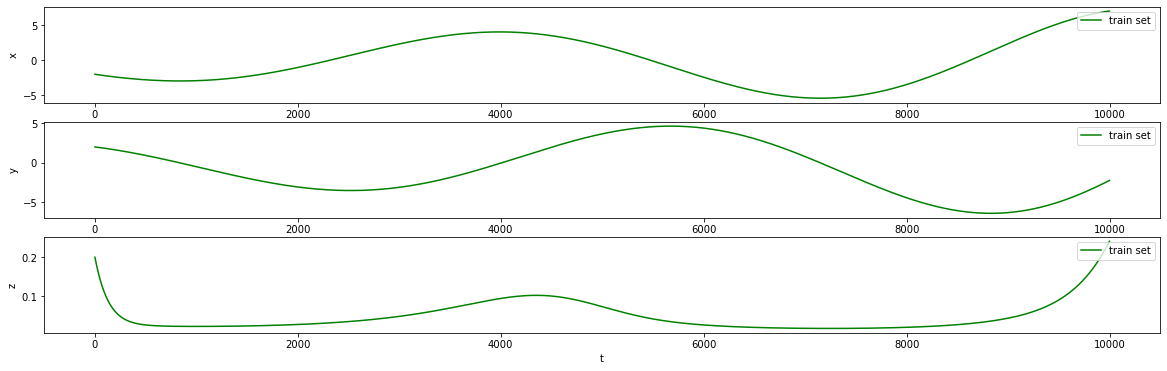

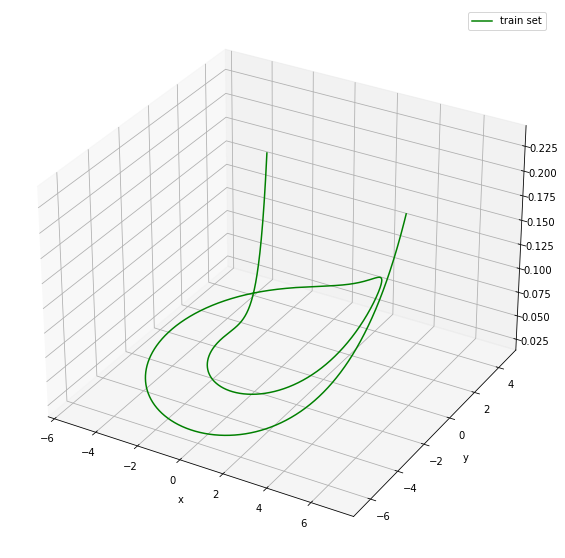

In [28]:
N = 10000
functions, start_point, step = Rossler()
x = trajectory(functions, start_point, N, step)
show(x)
show_3d(x)

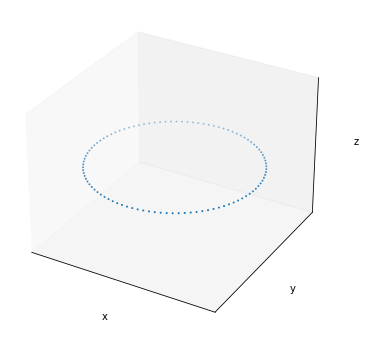

In [39]:
R = 1
Ninit = 100
points = np.array([[R*np.cos(2*np.pi/Ninit*i),R*np.sin(2*np.pi/Ninit*i),0] for i in range(Ninit)]) + np.array(start_point)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*points.T, s=1, cmap='Reds')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.grid(True)
plt.show()

In [40]:
def trajectory_sync(F, initial_point, X_drive, d=0, num_points=1e4, h=1e-2):
    assert (len(F) == len(initial_point))
    assert (initial_point[d] == X_drive[0])

    n = int(num_points)
    dim = len(initial_point)
    X = np.zeros([n, dim])

    X[0, :] = initial_point
    for k in range(1, n):
        dX = dxdt(F, X[k - 1, :], h * (k - 1), h)
        X[k, :] = X[k - 1, :] + dX
        X[k, d] = X_drive[k]

    return X.T

In [41]:
XRs = []
for sp in points:
    xr = trajectory_sync(functions, sp, x[2], d=2, num_points=N, h=step)
    XRs.append(xr)

In [42]:
# define some random data that emulates your indeded code:
NCURVES = 100
values = range(NCURVES)
cm = plt.get_cmap('nipy_spectral') 
cNorm  = colors.Normalize(vmin=-2, vmax=values[-1]+2) # 设置离散 value 的取值范围
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

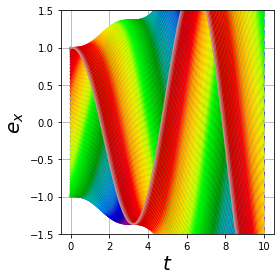

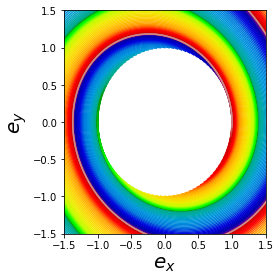

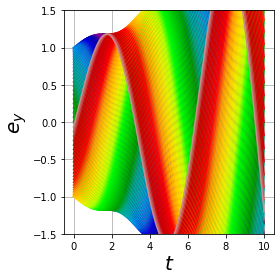

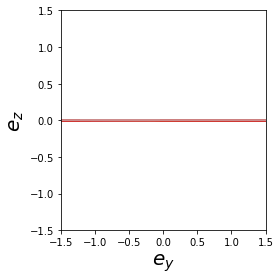

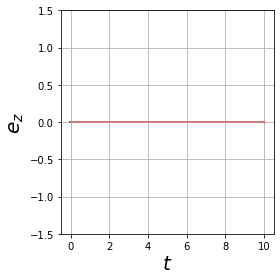

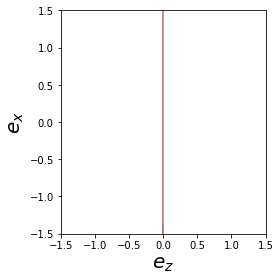

In [43]:
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}

ylabels = ['x','y','z']
scale = 1.5*R
for d in range(3):
    datas = [XRs[idx][d].T- x[d].T for idx in range(NCURVES)]  # 需要绘制的曲线

    fig = plt.figure(figsize=(4,4))
    for idx in range(NCURVES):
        colorVal = scalarMap.to_rgba(values[idx]) # 根据 value 提取颜色
        plt.plot([i*step for i in range(N)],datas[idx],color=colorVal)

    plt.grid()
    plt.ylim([-scale,scale])
    plt.ylabel(r'$e_{}$'.format(ylabels[d]), font)
    plt.xlabel(r'$t$', font)
    plt.tight_layout()
    plt.savefig(path+'/Rossler-z-e{}-t.pdf'.format(ylabels[d]))
    
    plt.figure(figsize=(4,4))
    for idx in range(NCURVES):
        colorVal = scalarMap.to_rgba(values[idx]) # 根据 value 提取颜色
        plt.plot(XRs[idx][d].T- x[d].T,XRs[idx][(d+1)%3].T- x[(d+1)%3].T,color=colorVal)
    plt.xlim([-scale,scale])
    plt.ylim([-scale,scale])
    plt.ylabel(r'$e_{}$'.format(ylabels[(d+1)%3]), font)
    plt.xlabel(r'$e_{}$'.format(ylabels[d]), font)
    plt.tight_layout()
    plt.savefig(path+'/Rossler-z-e{}-e{}.pdf'.format(ylabels[d],ylabels[(d+1)%3]))